In [1]:
import os
import sys

# torch modules
from torch import nn, optim, load
from torchvision import transforms, models

# Add to pythonpath so package imports work when run as module
# BREED_ID_DIR = os.path.abspath(os.path.dirname(__file__))
# PROJ_DIR = os.path.join(BREED_ID_DIR, os.pardir)
# Uncomment below and comment above two lines for use in jupyter notebook
PROJ_DIR = os.path.abspath(os.path.join(os.pardir, os.pardir))
print('proj dir:', PROJ_DIR)
if PROJ_DIR not in sys.path:
    sys.path.append(PROJ_DIR)

# Package modules
from breed_id.breed_id_utils import LABELS_CSV_PATH, SAVED_MODELS_DIR
from breed_id.breed_id_utils import TRANSFORM_NORM, TRANSFORM_IMG_SIZE
from breed_id.data_loader import DataLoaderGenerator
from breed_id.train import Trainer

proj dir: /home/johnny/civic-projects/saveallthepets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

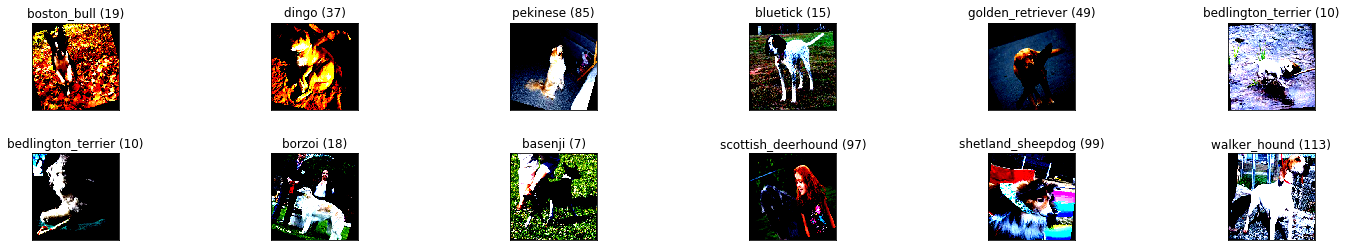

In [2]:
# Module constants
# Map to local directory of images
IMG_DIR = '/media/wdblack-1/saveallthepets/dog-breed-dataset/kaggle/train'
BATCH_SIZE = 32
# Imagenet models require 224x224 sized images except Inception which used 299
INPUT_SIZE = TRANSFORM_IMG_SIZE
VALIDATION_SPLIT = 0.20  # Train/validation subset ratio
RAND_STATE = 42  # Random state to help ensure reproducibility when an option
NUM_CLASSES = 120  # There are 120 breeds in this kaggle dataset

# 1. Define train and validation data transformers
train_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomRotation(degrees=25),
    transforms.ToTensor(),
    TRANSFORM_NORM
])
valid_transforms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    TRANSFORM_NORM
])

# 2. Define loader configurations and generate dataloaders
loader_generator = DataLoaderGenerator(labels_path=LABELS_CSV_PATH,
                                       img_dir=IMG_DIR,
                                       split_size=VALIDATION_SPLIT,
                                       rand_state=RAND_STATE)
dataloaders = loader_generator.get_data_loaders(batch_size=BATCH_SIZE,
                                                shuffle=True, num_workers=4,
                                                pin_memory=True,
                                                train_transform=train_transforms,
                                                valid_transform=valid_transforms)
train_loader = dataloaders['train']
valid_loader = dataloaders['validation']

# Visualize a handful to ensure transformations make sense (OPTIONAL)
show_sample = True
if show_sample:
    loader_generator.show_sample_images(transform=train_transforms)

In [3]:
# 3. Define network model and freeze layers for use as feature extractor
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# 4. Reshape fully-connected layer
# Note: the name or structure is unique to each Imagenet model
# Useful reference link:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks
model.fc = nn.Sequential(
    nn.Linear(2048, NUM_CLASSES)
)

# OPTIONAL: load saved model
load_model = False
if load_model:
    model_checkpoint = load(os.path.join(SAVED_MODELS_DIR, 'R50_1nodes.pt'))
    print(model_checkpoint.keys())
    model.load_state_dict(model_checkpoint['state_dict'])

In [4]:
model.fc.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0136, -0.0207, -0.0179,  ...,  0.0047,  0.0140,  0.0209],
                      [ 0.0199, -0.0015, -0.0219,  ..., -0.0186,  0.0068,  0.0041],
                      [ 0.0125,  0.0128,  0.0130,  ..., -0.0047, -0.0030,  0.0181],
                      ...,
                      [-0.0125, -0.0106,  0.0052,  ..., -0.0177,  0.0221,  0.0072],
                      [-0.0218,  0.0022,  0.0105,  ...,  0.0082, -0.0104, -0.0020],
                      [ 0.0013,  0.0021, -0.0007,  ..., -0.0197,  0.0170,  0.0135]])),
             ('0.bias',
              tensor([-0.0068,  0.0182,  0.0203,  0.0033,  0.0008, -0.0015, -0.0130, -0.0003,
                      -0.0142, -0.0020, -0.0024,  0.0191, -0.0093, -0.0048, -0.0058,  0.0165,
                      -0.0214,  0.0062, -0.0190, -0.0136,  0.0142,  0.0214,  0.0214,  0.0081,
                      -0.0030, -0.0219, -0.0141,  0.0121, -0.0071,  0.0105, -0.0094,  0.0149,
                       0.0190, -0.0060, 

In [7]:
# 5. Define configurations for training: learning rate, loss model (criterion),
# optimizer, and scheduler (optional)
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=lr)
# Uncomment below and comment above is using unfrozen feature extractor layer
# optimizer = optim.Adam(model.parameters(), lr=lr)
# Allows for decreasing the learning rate per epoch rate
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,
                                      step_size=10, gamma=0.1)

In [8]:
# 6. Train model
# Base name for saving model checkpoints
base_name = 'R50_1nodes'
epochs = 50
CUDA_INT = 1
trainer = Trainer(train_loader=train_loader, validation_loader=valid_loader,
                  criterion=criterion, optimizer=optimizer,
                  scheduler=scheduler, save_dir=SAVED_MODELS_DIR)
model_checkpoint = trainer.train_model(arch=base_name, model=model,
                                       epochs=epochs, device_int=CUDA_INT,
                                       unfreeze=False, checkpoint=None)

Training model on cuda:1


Epoch: 1 - completed in: 0m 53s
	Training Loss: 2.292771 	Validation Loss: 1.128065
	Training acc: 49.053 	Validation acc: 69.656
	Training mcc: 0.487 	Validation mcc: 0.695
Validation loss decreased (inf --> 1.128065).  Saving model ...
	Model saved as: R50_1nodes_model_0.pt
Epoch: 2 - completed in: 0m 33s
	Training Loss: 1.041712 	Validation Loss: 0.918429
	Training acc: 71.711 	Validation acc: 73.182
	Training mcc: 0.715 	Validation mcc: 0.730
Validation loss decreased (1.128065 --> 0.918429).  Saving model ...
	Model saved as: R50_1nodes_model_1.pt
Epoch: 3 - completed in: 0m 34s
	Training Loss: 0.871980 	Validation Loss: 0.843442
	Training acc: 74.572 	Validation acc: 74.672
	Training mcc: 0.744 	Validation mcc: 0.745
Validation loss decreased (0.918429 --> 0.843442).  Saving model ...
	Model saved as: R50_1nodes_model_2.pt
Epoch: 4 - completed in: 0m 35s
	Training Loss: 0.784861 	Validation Loss: 0.824420
	Training acc: 77.032 	Validation acc: 76.401
	Training mcc: 0.768 	Validat

Epoch: 42 - completed in: 0m 36s
	Training Loss: 0.310546 	Validation Loss: 0.745614
	Training acc: 90.642 	Validation acc: 77.992
	Training mcc: 0.906 	Validation mcc: 0.778
Epoch: 43 - completed in: 0m 37s
	Training Loss: 0.315442 	Validation Loss: 0.744391
	Training acc: 90.619 	Validation acc: 78.285
	Training mcc: 0.906 	Validation mcc: 0.781
Epoch: 44 - completed in: 0m 36s
	Training Loss: 0.316772 	Validation Loss: 0.752849
	Training acc: 90.533 	Validation acc: 77.938
	Training mcc: 0.905 	Validation mcc: 0.778
Epoch: 45 - completed in: 0m 37s
	Training Loss: 0.317496 	Validation Loss: 0.749082
	Training acc: 90.582 	Validation acc: 78.074
	Training mcc: 0.905 	Validation mcc: 0.779
Epoch: 46 - completed in: 0m 37s
	Training Loss: 0.316216 	Validation Loss: 0.764523
	Training acc: 90.480 	Validation acc: 77.851
	Training mcc: 0.904 	Validation mcc: 0.777
Epoch: 47 - completed in: 0m 36s
	Training Loss: 0.311316 	Validation Loss: 0.756653
	Training acc: 90.687 	Validation acc: 7

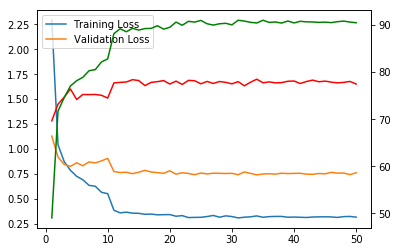

In [9]:
# 7. Visualize result of training
train_loss = model_checkpoint['train_loss']
valid_loss = model_checkpoint['valid_loss']
train_acc = model_checkpoint['train_acc']
valid_acc = model_checkpoint['valid_acc']
train_mcc = model_checkpoint['train_mcc']
valid_mcc = model_checkpoint['valid_mcc']
train_y_true = model_checkpoint['train_y_true']
train_y_pred = model_checkpoint['train_y_pred']
valid_y_true = model_checkpoint['valid_y_true']
valid_y_pred = model_checkpoint['valid_y_pred']

# Plot loss vs accuracy
trainer.plot_loss(arch=base_name, train_loss=train_loss,
                  valid_loss=valid_loss, train_metric=train_acc,
                  valid_metric=valid_acc, metric_title='Accuracy',
                  train_metric_label='Train Accuracy',
                  valid_metric_label='Validation Accuracy')
# # Plot loss vs mcc
# trainer.plot_loss(arch=base_name, train_loss=train_loss,
#                   valid_loss=valid_loss, train_metric=train_mcc,
#                   valid_metric=valid_mcc, metric_title='MCC',
#                   train_metric_label='Train MCC',
#                   valid_metric_label='Validation MCC')
# # Plot train confusion matrix
# trainer.plot_confusion_matrix(y_true=train_y_true, y_pred=train_y_pred,
#                               title=f'{base_name} Train Confusion Matrix')
# # Plot validation confusion matrix
# trainer.plot_confusion_matrix(y_true=valid_y_true, y_pred=valid_y_pred,
#                               title=f'{base_name} Valid Confusion Matrix')

In [11]:
model.fc.state_dict()

OrderedDict([('0.weight',
              tensor([[ 3.1199e-03, -1.0238e-02, -1.5068e-02,  ..., -1.7399e-03,
                       -1.0305e-02, -4.2929e-05],
                      [-6.2494e-02,  5.1429e-03,  4.9980e-03,  ..., -6.8468e-02,
                        2.7810e-02,  2.4630e-02],
                      [-3.4955e-02, -2.8282e-02, -4.8433e-02,  ...,  2.4843e-02,
                       -6.2807e-03, -4.9026e-03],
                      ...,
                      [-1.2281e-02,  1.8028e-02, -2.2006e-03,  ...,  1.0828e-02,
                        8.8914e-02, -6.3832e-03],
                      [-9.8610e-02, -3.4854e-02,  6.8784e-02,  ...,  1.4572e-02,
                       -5.4067e-02, -2.6457e-02],
                      [-4.2185e-02,  4.4427e-02,  1.1014e-02,  ..., -5.1584e-02,
                       -5.0729e-02,  4.1862e-02]], device='cuda:1')),
             ('0.bias',
              tensor([ 0.0024,  0.0020,  0.0240, -0.0112,  0.0073, -0.0082, -0.0120, -0.0190,
                      -

In [12]:
# Retrain with unfrozen feature extraction layers
base_name += '_unfrozen'
lr = 0.001
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=lr)
# Uncomment below and comment above is using unfrozen feature extractor layer
optimizer = optim.Adam(model.parameters(), lr=lr)
# Allows for decreasing the learning rate per epoch rate
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer,
                                      step_size=25, gamma=0.1)

OrderedDict([('0.weight',
              tensor([[ 3.1199e-03, -1.0238e-02, -1.5068e-02,  ..., -1.7399e-03,
                       -1.0305e-02, -4.2929e-05],
                      [-6.2494e-02,  5.1429e-03,  4.9980e-03,  ..., -6.8468e-02,
                        2.7810e-02,  2.4630e-02],
                      [-3.4955e-02, -2.8282e-02, -4.8433e-02,  ...,  2.4843e-02,
                       -6.2807e-03, -4.9026e-03],
                      ...,
                      [-1.2281e-02,  1.8028e-02, -2.2006e-03,  ...,  1.0828e-02,
                        8.8914e-02, -6.3832e-03],
                      [-9.8610e-02, -3.4854e-02,  6.8784e-02,  ...,  1.4572e-02,
                       -5.4067e-02, -2.6457e-02],
                      [-4.2185e-02,  4.4427e-02,  1.1014e-02,  ..., -5.1584e-02,
                       -5.0729e-02,  4.1862e-02]], device='cuda:1')),
             ('0.bias',
              tensor([ 0.0024,  0.0020,  0.0240, -0.0112,  0.0073, -0.0082, -0.0120, -0.0190,
                      -

In [13]:
model_checkpoint = trainer.train_model(arch=base_name, model=model,
                                       epochs=100, device_int=CUDA_INT,
                                       unfreeze=True,
                                       checkpoint=model_checkpoint)

Training model on cuda:1


Epoch: 35 - completed in: 1m 33s
	Training Loss: 0.299747 	Validation Loss: 0.755418
	Training acc: 91.382 	Validation acc: 78.036
	Training mcc: 0.913 	Validation mcc: 0.779
Validation loss decreased (0.759874 --> 0.755418).  Saving model ...
	Model saved as: R50_1nodes_model_34.pt
Epoch: 36 - completed in: 1m 37s
	Training Loss: 0.314428 	Validation Loss: 0.752350
	Training acc: 90.649 	Validation acc: 77.753
	Training mcc: 0.906 	Validation mcc: 0.776
Validation loss decreased (0.755418 --> 0.752350).  Saving model ...
	Model saved as: R50_1nodes_model_35.pt
Epoch: 37 - completed in: 1m 37s
	Training Loss: 0.307768 	Validation Loss: 0.736883
	Training acc: 90.565 	Validation acc: 77.835
	Training mcc: 0.905 	Validation mcc: 0.777
Validation loss decreased (0.752350 --> 0.736883).  Saving model ...
	Model saved as: R50_1nodes_model_36.pt
Epoch: 38 - completed in: 1m 37s
	Training Loss: 0.316289 	Validation Loss: 0.750383
	Training acc: 90.480 	Validation acc: 77.606
	Training mcc: 0.

Epoch: 79 - completed in: 1m 37s
	Training Loss: 0.311924 	Validation Loss: 0.754923
	Training acc: 90.687 	Validation acc: 77.406
	Training mcc: 0.906 	Validation mcc: 0.772
Epoch: 80 - completed in: 1m 37s
	Training Loss: 0.305760 	Validation Loss: 0.745368
	Training acc: 91.020 	Validation acc: 77.899
	Training mcc: 0.910 	Validation mcc: 0.777
Epoch: 81 - completed in: 1m 37s
	Training Loss: 0.314393 	Validation Loss: 0.744796
	Training acc: 90.564 	Validation acc: 77.851
	Training mcc: 0.905 	Validation mcc: 0.777
Epoch: 82 - completed in: 1m 37s
	Training Loss: 0.315226 	Validation Loss: 0.747157
	Training acc: 90.680 	Validation acc: 77.997
	Training mcc: 0.906 	Validation mcc: 0.778
Epoch: 83 - completed in: 1m 37s
	Training Loss: 0.313725 	Validation Loss: 0.752216
	Training acc: 90.216 	Validation acc: 77.958
	Training mcc: 0.902 	Validation mcc: 0.778
Epoch: 84 - completed in: 1m 37s
	Training Loss: 0.312271 	Validation Loss: 0.761532
	Training acc: 90.613 	Validation acc: 7

Epoch: 126 - completed in: 1m 37s
	Training Loss: 0.308569 	Validation Loss: 0.739672
	Training acc: 90.700 	Validation acc: 77.997
	Training mcc: 0.906 	Validation mcc: 0.778
Epoch: 127 - completed in: 1m 37s
	Training Loss: 0.306865 	Validation Loss: 0.751629
	Training acc: 91.154 	Validation acc: 77.977
	Training mcc: 0.911 	Validation mcc: 0.778
Epoch: 128 - completed in: 1m 37s
	Training Loss: 0.312835 	Validation Loss: 0.770081
	Training acc: 90.517 	Validation acc: 77.499
	Training mcc: 0.904 	Validation mcc: 0.773
Epoch: 129 - completed in: 1m 37s
	Training Loss: 0.308920 	Validation Loss: 0.765423
	Training acc: 90.982 	Validation acc: 77.465
	Training mcc: 0.909 	Validation mcc: 0.773
Epoch: 130 - completed in: 1m 37s
	Training Loss: 0.313718 	Validation Loss: 0.735823
	Training acc: 90.614 	Validation acc: 77.802
	Training mcc: 0.905 	Validation mcc: 0.776
Epoch: 131 - completed in: 1m 37s
	Training Loss: 0.314913 	Validation Loss: 0.753538
	Training acc: 90.252 	Validation 

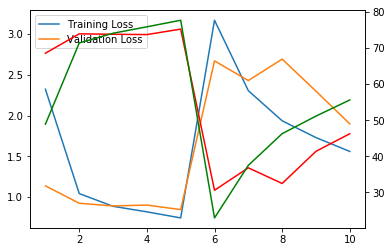

In [8]:
# 7. Visualize result of training
train_loss = model_checkpoint['train_loss']
valid_loss = model_checkpoint['valid_loss']
train_acc = model_checkpoint['train_acc']
valid_acc = model_checkpoint['valid_acc']
train_mcc = model_checkpoint['train_mcc']
valid_mcc = model_checkpoint['valid_mcc']
train_y_true = model_checkpoint['train_y_true']
train_y_pred = model_checkpoint['train_y_pred']
valid_y_true = model_checkpoint['valid_y_true']
valid_y_pred = model_checkpoint['valid_y_pred']

# Plot loss vs accuracy
trainer.plot_loss(arch=base_name, train_loss=train_loss,
                  valid_loss=valid_loss, train_metric=train_acc,
                  valid_metric=valid_acc, metric_title='Accuracy',
                  train_metric_label='Train Accuracy',
                  valid_metric_label='Validation Accuracy')